In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.2 MB/s eta 0:00:00


In [2]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 KB 49.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
from transformers import BertModel, BertTokenizer
import joblib


In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('/content/drive/My Drive/DA2/rating.csv')
df.head()

,Column1,Column2,Column3,Column4
0,0,https://shopee.vn/Tee-basic-ss1-CREWZ-%C3%A1o-...,1,Áo đẹp lắm giao đúng cỡ mặc thoải mái hài lòng
1,0,https://shopee.vn/Tee-basic-ss1-CREWZ-%C3%A1o-...,1,Chất liệu: vải mỏng ạ Màu sắc: trắng Đúng vớ...
2,0,https://shopee.vn/Tee-basic-ss1-CREWZ-%C3%A1o-...,1,Chất liệu: ok Màu sắc: ok Đúng với mô tả: ok...
3,0,https://shopee.vn/Tee-basic-ss1-CREWZ-%C3%A1o-...,1,Chất liệu: vair gif as ko bieets dduowjc Màu ...
4,0,https://shopee.vn/Tee-basic-ss1-CREWZ-%C3%A1o-...,1,Hàng hơi rộng Okk mẹ tao nói chuyện với em có...


In [6]:
df=df[["Column3","Column4"]]
df.columns=['label','text']

In [7]:
df["label"]=df["label"].replace(5,0)
df["label"]=df["label"].replace(4,0)
df["label"]=df["label"].replace(3,1)
df["label"]=df["label"].replace(2,1)

In [8]:
df['text'] = df['text'].str.replace('[^\w\s]','', regex = True)
df['text'] = df['text'].astype(str).str.lower()

In [9]:
df.sample(5)

,label,text
4307,1,chất liệu toits màu sắc đen đúng với mô tả đ...
2941,1,ổn
3307,1,giao hàng nhanh áo đẹp nha mọi người nên mua...
2205,1,sản phẩm chất lượng tốt đáng đồng tiền bát gạo
3592,1,đẹp quá


In [10]:
def standardize_data(row):
    # remove stopword
    # Remove . ? , at index final
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Remove all . , " ... in sentences
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")

    row = row.strip()
    return row

In [11]:
from underthesea import word_tokenize
# Tokenizer
def tokenizer(row):
    return word_tokenize(row, format="text")

In [12]:
print(df)

      label                                               text
0         1    áo đẹp lắm giao đúng cỡ mặc thoải mái hài lòng 
1         1  chất liệu vải mỏng ạ  màu sắc trắng  đúng với ...
2         1  chất liệu ok  màu sắc ok  đúng với mô tả ok  á...
3         1  chất liệu vair gif as ko bieets dduowjc  màu s...
4         1  hàng hơi rộng  okk mẹ tao nói chuyện với em có...
...     ...                                                ...
5914      0          shop làm việc thái độ tệ với khách hàng10
5915      0                                            hàng cc
5916      0                                         chửi khách
5917      0                                             ko đẹp
5918      0                                           nữvvvvvv

[5919 rows x 2 columns]


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


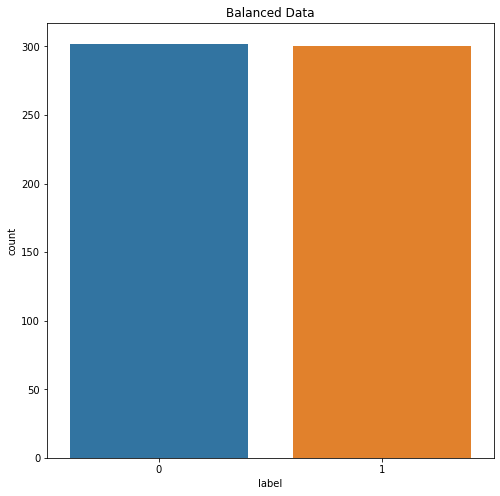

In [14]:
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['label'] == 0]

#Randomly select 300 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['label'] == 1].sample(n=300,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('label', data=normalized_df)
plt.title('Balanced Data')
plt.show()

In [15]:
normalized_df

,label,text
942,0,không trong hình áo mỏng như cc3
897,0,chất liệu ko đc giầy lắm màu sắc xanh đậm đú...
5890,0,quần quá xấu luôn sai màu đặt size 28 mà ống r...
5860,0,shop giao nhầm size cho mình
901,0,shop như cái l hình 1kiểu áo 1kiểu
...,...,...
1442,1,màu sắc đen đúng với mô tả đúng siêu đẹp luôn ạ
453,1,chất liệu non stop màu sắc gold đúng với mô ...
4372,1,chất liệu tôt màu sắc vang đúng với mô tả ok...
1351,1,đúng với mô tả rất ok mua cho em trai đeo đi h...


In [16]:
'''
Load pretrain model/ tokenizers
'''
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#encode lines
tokenized = normalized_df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens = True)))
print('encode',tokenized[563])
# decode
print('decode',tokenizer.decode(tokenized[563]))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

encode [101, 11834, 22470, 7929, 102]
decode [CLS] chat lieu ok [SEP]


In [19]:
# get lenght max of tokenized
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
print('max len:', max_len)

# if lenght of tokenized not equal max_len , so padding value 0
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print('padded:', padded[1])
print('len padded:', padded.shape)

#get attention mask ( 0: not has word, 1: has word)
attention_mask = np.where(padded ==0, 0,1)
print('attention mask:', attention_mask[1])

# Convert input to tensor
padded = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)


# Train model
with torch.no_grad():
    last_hidden_states = model(padded, attention_mask =attention_mask)
#     print('last hidden states:', last_hidden_states)

features = last_hidden_states[0][:,0,:].numpy()
print('features:', features)

X_train, X_test, y_train, y_test = train_test_split(features, normalized_df['label'], test_size=0.3, random_state=42)

cl = LogisticRegression()
cl.fit(X_train, y_train)

# # Save model
# joblib.dump(cl, 'save_model.pkl')
sc = cl.score(X_test, y_test)
print('score:', sc)

max len: 119
padded: [  101 11834 22470 12849  1102  2278 27699  2100 16983  5003  2226 17266
  1060  2319  2232  1102  3286  1102  5575 29536  2072  9587 11937  1047
  3270  2278  5003  2226 12436  2072 12849  1102 13699  5003  2226  1060
  2319  2232  1102  3286 12849 21025  5063 19817  5063  2678  2509   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]
len padded: (602, 119)
attention mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KIEM TRA MODEL

In [20]:
test = ['giao nhầm size', 'quần mặc đẹp']
testdf = pd.DataFrame(test, columns=['text'])
testdf

,text
0,giao nhầm size
1,quần mặc đẹp


In [21]:
testtokenized = testdf['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens = True)))

In [22]:
# get lenght max of tokenized
testmax_len = 0
for i in testtokenized.values:
    if len(i) > testmax_len:
        testmax_len = len(i)

# if lenght of tokenized not equal max_len , so padding value 0
testpadded = np.array([i + [0]*(testmax_len-len(i)) for i in testtokenized.values])

#get attention mask ( 0: not has word, 1: has word)
testattention_mask = np.where(testpadded ==0, 0,1)

# Convert input to tensor
testpadded = torch.tensor(testpadded)
testattention_mask = torch.tensor(testattention_mask)

# Load model
with torch.no_grad():
    testlast_hidden_states = model(testpadded, attention_mask =testattention_mask)

testfeatures = testlast_hidden_states[0][:,0,:].numpy()
    
testresult = cl.predict(testfeatures)
print(testresult)

[0 1]


KET QUA TRA VE CHO THAY MODEL HOAT DONG TOT

In [24]:
# Save model
joblib.dump(cl, '/content/drive/My Drive/DA2/bert')

['/content/drive/My Drive/DA2/bert']